# **Meso Analysis**

Se emplea la red de Kárate de Zachary

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx
import numpy as np
import pandas as pd
from pyvis.network import Network
import matplotlib.cm as cm


colormap = plt.cm.tab20

def str_color(r, g, b, a):
    '''
    Convierte un color RGBA en formato decimal (0-1) a un código hexadecimal de color.
    - Toma los valores de rojo (r), verde (g), azul (b) y alfa (a) como entrada.
    - Convierte cada componente a un entero entre 0 y 255.
    - Retorna una cadena en formato hexadecimal, útil para colorear nodos en visualizaciones.
    '''
    return "#" + format(int(r*255), f'0{2}x') + format(int(g*255), f'0{2}x') + format(int(b*255), f'0{2}x') + format(int(a*255), f'0{2}x')

def assign_colors(values):
    '''
    Asigna colores a una lista de valores numéricos.
    - Usa un mapa de colores (colormap) para convertir cada valor en un color RGBA.
    - Convierte los colores RGBA a formato hexadecimal utilizando `str_color`.
    - Retorna una lista de colores en formato hexadecimal, que se puede usar para colorear nodos.
    '''
    colors = [str_color(*colormap(v)) for v in values]
    return colors

def draw_communities(coms, ax=None):
    '''
    Dibuja el grafo coloreando los nodos según sus comunidades.
    - `coms` es un diccionario que asigna cada nodo a una comunidad.
    - Los colores se asignan a los nodos en función de sus comunidades.
    - Calcula la modularidad ( Q ) de la partición y la muestra como título del gráfico.
    - Si `ax` se proporciona, dibuja el grafo en ese eje; de lo contrario, usa la figura actual.
    '''
    colors = assign_colors([coms[n] for n in G.nodes()])
    nx.draw(G, with_labels=True, ax=ax, node_color=colors)
    ax.set_title(f"Q:{nx.community.modularity(G, to_communities_list(coms)):.4f}")

def to_communities_list(coms):
    '''
    Convierte un diccionario de asignación de comunidades en una lista de listas.
    - `coms` es un diccionario que asigna cada nodo a una comunidad.
    - Se genera una lista de listas, donde cada sublista contiene los nodos de una comunidad.
    - Esto es útil para calcular métricas como modularidad.
    - La comunidad 0 corresponde a la primera lista, la 1 a la segunda, y así sucesivamente.
    '''
    c_pos = {v: i for i, v in enumerate(set(coms.values()))}  # Asigna índices únicos a las comunidades.
    num_c = len(c_pos)  # Número de comunidades.
    com_list = [[] for _ in range(num_c)]  # Inicializa listas vacías para cada comunidad.

    for k, v in coms.items():
        com_list[c_pos[v]].append(k)  # Agrega cada nodo a su comunidad correspondiente.

    return com_list

def to_communities_dict(coms):
    '''
    Convierte un diccionario de asignación de comunidades en un formato inverso.
    - `coms` es un diccionario que asigna cada nodo a una comunidad.
    - Devuelve un diccionario donde las claves son las comunidades y los valores son listas de nodos.
    - Esto permite agrupar nodos por comunidad en un formato accesible.
    '''
    inv_map = {}
    for k, v in coms.items():
        inv_map[v] = inv_map.get(v, []) + [k]  # Agrega nodos a su comunidad en el diccionario inverso.

    return inv_map

In [3]:
G = nx.karate_club_graph()

**Visualización de la red:**

In [35]:
centrality = nx.degree_centrality(G)

# top 3 nodes by degree centrality
display(pd.DataFrame.from_dict(centrality, orient='index', columns=['degree']).sort_values(by='degree', ascending=False).head(3))

# draw network
nx.set_node_attributes(G, {n:f"{v}" for n,v in centrality.items()}, 'title')
nx.set_node_attributes(G, {n:v for n,v in zip(centrality.keys(), assign_colors(centrality.values()))}, 'color')
nx.set_node_attributes(G, {n:f"{n}" for n in G.nodes}, 'label')
nx.set_node_attributes(G, "dot", 'shape')

net = Network(notebook=True, height='500px', width='100%', bgcolor="#DCDCDC")
net.from_nx(G)
net.show('visualization.html')

,degree
33,0.515152
0,0.484848
32,0.363636


visualization.html


## Modularidad de las comunidades del grafo
Las comunidades se definen por el atributo de los nodos 'club'

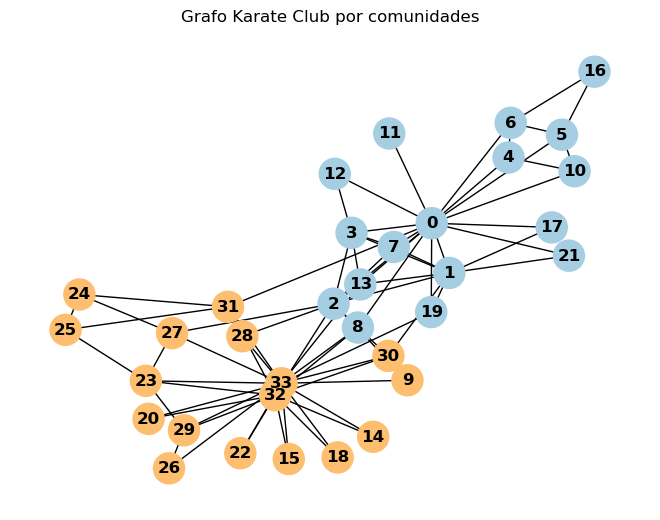

In [62]:
unique_clubs = set(nx.get_node_attributes(G, 'club').values())

color_map = {club: cm.Paired(i / len(unique_clubs)) for i, club in enumerate(unique_clubs)} # Se asigna un color unico a cada comunidad
colors = [color_map[G.nodes[node]['club']] for node in G.nodes()]                           # Se accede al atributo club de los nodos para recuperar su color asociado

nx.draw(G, with_labels=True, node_color=colors, font_weight='bold', node_size=500, font_color='black')

plt.title("Grafo Karate Club por comunidades")
plt.show()

In [63]:
### Calculamos la modularidad de las dos comunidades

communities = {}
for node, data in G.nodes(data=True): # data contiene los atributos del nodo
    club = data['club']
    if club not in communities:
        communities[club] = []
    communities[club].append(node)

community_list = list(communities.values()) 
modularity = nx.community.modularity(G, community_list)
print(f"La modularidad del grafo con las comunidades es: {modularity:.4f}")

La modularidad del grafo con las comunidades es: 0.3582


In [65]:
nodes, data = zip(*list(G.nodes(data=True)))
df_coms = pd.DataFrame(data, index=nodes).reset_index().groupby("club").aggregate(lambda x: list(x))
q = nx.community.modularity(G, df_coms["index"].values.tolist())
print(f"Modularidad de la red separada en comunidades: {q:.4f}")

Modularidad de la red separada en comunidades por el Algoritmo de Leiden: 0.3582


## Algoritmo de Leiden

In [49]:
!pip install python-igraph --quiet
!pip install leidenalg --quiet

  You can safely remove it manually.


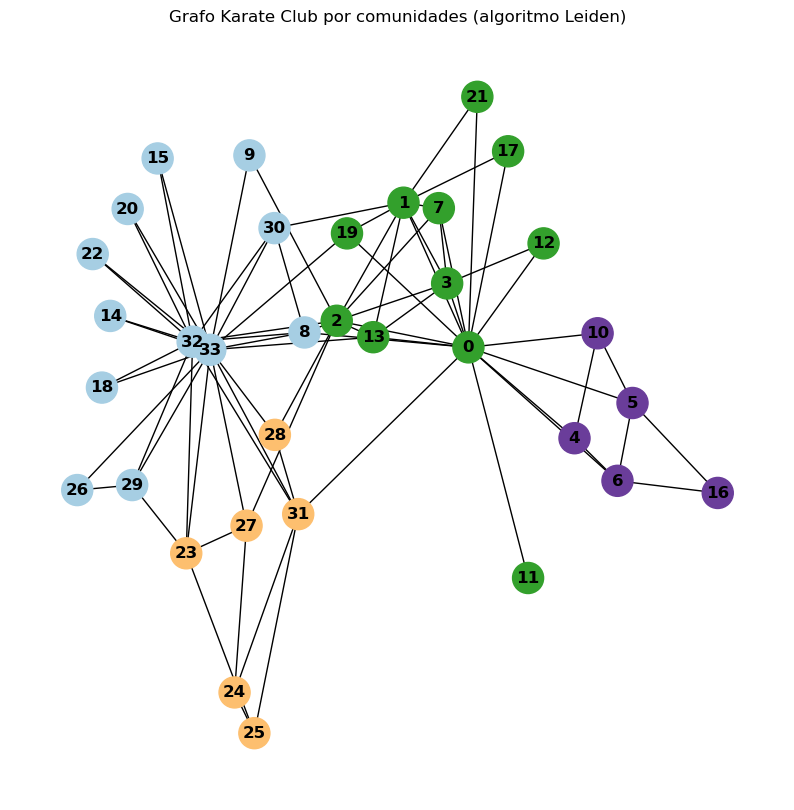

In [66]:
from cdlib.algorithms import leiden

nx.set_edge_attributes(G, 1, "weight")

community_map = leiden(G).to_node_community_map() # Algoritmo de Leiden. community_map es un diccionario {0: [0], 1: [0], 2: [1]...}, siendo [0] la comunidad a la que pertenece un nodo
community_map = {node: community[0] for node, community in community_map.items()} # Obtenemos las comunidades de cada nodo para almacenar el dict = {0: 0, 1: 0, 2: 1...},

unique_communities = set(community_map.values())
color_map = {community: cm.Paired(i / len(unique_communities)) for i, community in enumerate(unique_communities)}

_, ax = plt.subplots(1, figsize=(10, 10))

colors = [color_map[community_map[node]] for node in G.nodes()]

nx.set_node_attributes(G, {node: {"color": color} for node, color in zip(G.nodes(), colors)})
nx.draw(G, with_labels=True, node_color=colors, font_weight='bold', node_size=500, font_color='black', ax=ax)

plt.title("Grafo Karate Club por comunidades (algoritmo Leiden)")
plt.show()

**Queda calcular la modularidad**

In [69]:
# Se obtienen los nodos y sus atributos de color
nodes, data = zip(*list(G.nodes(data=True)))

# Se convierten los atributos de los nodos (como el color) en un DataFrame de pandas
df_coms = pd.DataFrame(data, index=nodes).reset_index().groupby("color").aggregate(lambda x: list(x))

# Se calcula la modularidad de la partición del grafo utilizando los colores de las comunidades como partición
q = nx.community.modularity(G, df_coms["index"].values.tolist())

print(f"Modularidad de la red separada en comunidades por el Algoritmo de Leiden: {q:.4f}")

Modularidad de la red separada en comunidades por el Algoritmo de Leiden: 0.4198


## Dendograma de comunidades - Alg. Girvan-Newman

Un dendograma es un tipo de diagrama en forma de árbol que se utiliza para representar relaciones jerárquicas entre elementos. Es común en análisis de agrupamiento (clustering) y en detección de comunidades en redes. En el contexto de grafos y comunidades, un dendograma muestra cómo las comunidades se agrupan o dividen a diferentes niveles.

Componentes clave de un dendograma
1. Nodos y hojas:

- Las hojas del dendograma representan los elementos individuales (como nodos en un grafo).
- Los nodos internos representan comunidades más grandes formadas por la unión de nodos o grupos más pequeños.

2. Niveles jerárquicos:

- Cada nivel del dendograma corresponde a una partición del conjunto original.
- En los niveles inferiores, hay más divisiones (comunidades más pequeñas). En los niveles superiores, las comunidades se agrupan en conjuntos más grandes.

3. Altura del dendograma:

- Indica el nivel jerárquico. Un nivel más alto significa que se agrupan más elementos en una comunidad.

### Dendograma y visualizacion de las comunidades en formato de grafo

In [81]:
import networkx as nx
from networkx.algorithms.community import girvan_newman
import matplotlib.pyplot as plt

dendrogram = girvan_newman(G) # generador de comunidades en niveles

for level, communities in enumerate(dendrogram):
    community_list = [list(c) for c in communities]
    
    modularity_value = nx.community.modularity(G, community_list)
    print(f"Nivel {level + 1}: Modularidad = {modularity_value:.4f}")
    
    if level == 2:  # Cambiar para más niveles
        break

Nivel 1: Modularidad = 0.3600
Nivel 2: Modularidad = 0.3488
Nivel 3: Modularidad = 0.3632


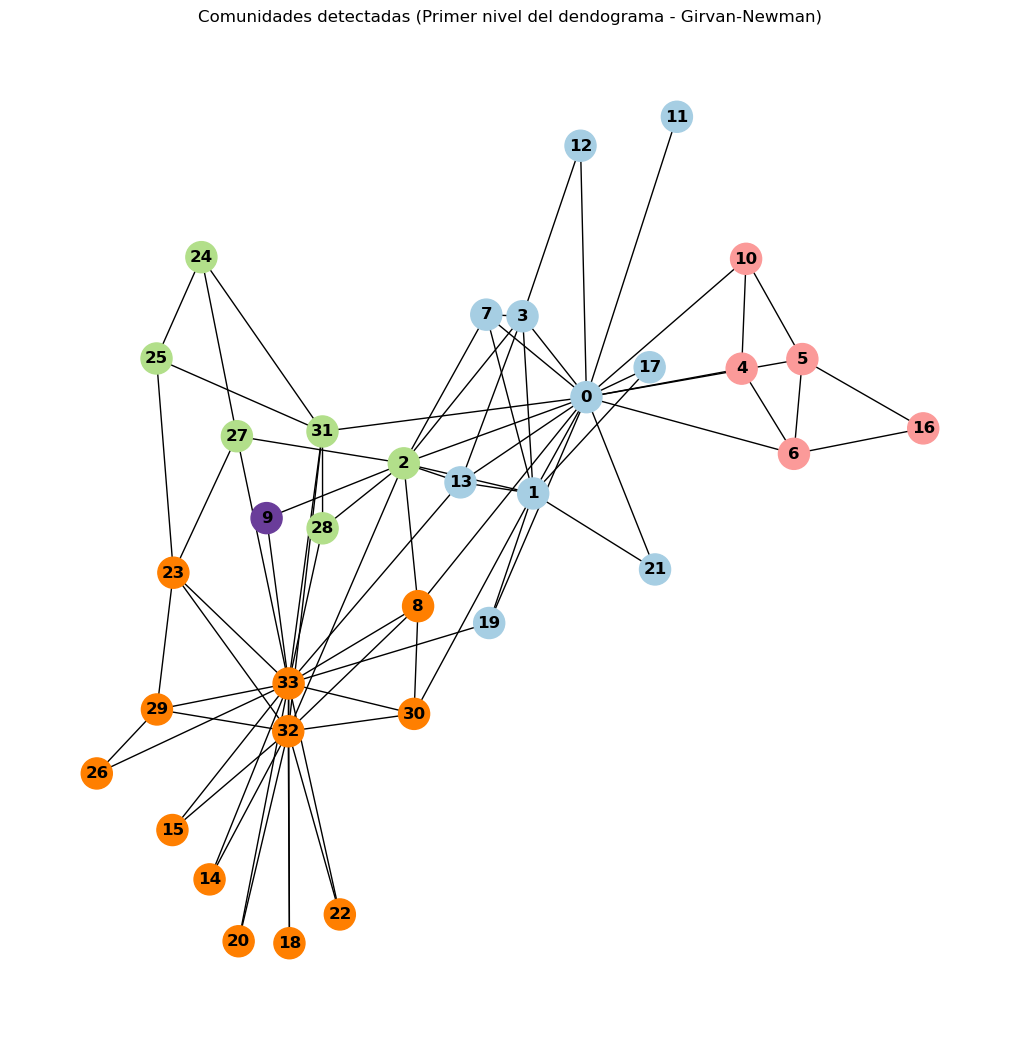

In [82]:
import matplotlib.cm as cm

# Calculamos las comunidades en el nivel 3 + 1 = 4 (5 comunidades)
first_level = next(dendrogram)
communities = [list(c) for c in first_level]


color_map = {i: cm.Paired(i / len(communities)) for i in range(len(communities))}
node_colors = []

for node in G.nodes():
    for idx, community in enumerate(communities):
        if node in community:
            node_colors.append(color_map[idx])
            break

plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=True, node_color=node_colors, font_weight='bold', node_size=500, font_color='black')
plt.title("Comunidades detectadas (Primer nivel del dendograma - Girvan-Newman)")
plt.show()

### Dendograma y visualización con forma de árbol

[set(c) for c in dendrogram_data[level - 1]] = [{0, 1, 2}, {3, 4, 5}]

frozenset.union({0, 1, 2}, {3, 4, 5}) = frozenset({0, 1, 2, 3, 4, 5})

- '*' (desempaquetar): Pasa los conjuntos individuales como argumentos separados a la función union.
- frozenset.union(): Combina todos los conjuntos en un único conjunto que representa a todos los nodos de las comunidades en el nivel anterior.

In [92]:
!python --version

Python 3.12.3


*El siguiente bloque de codigo no pinta correctamente el arbol por un problema de instalacion del layout de árbol en Windows*

In [ ]:
dendrogram_data = list(girvan_newman(G)) # Se almacenan todos los niveles del generador en dendograma

# Grafo jerárquico dirigido para representar el dendograma
dendrogram_tree = nx.DiGraph()  


level = 0
node_mapping = {frozenset(G.nodes()): f"L{level}"} # conjunto de todos los nodos del grafo inicial declarado como un conjunto inmutable
dendrogram_tree.add_node(f"L{level}", nodes=frozenset(G.nodes()))  # Nodo raíz con id = L{x} y tiene todos los nodos del grafo


for communities in dendrogram_data: # por cada nivel
    level += 1
    for community in communities: # por cada comunidad dentro de un nivel
        parent = node_mapping[frozenset.union(*[frozenset(c) for c in dendrogram_data[level - 1]])]  # el contenido dentro de la union parsea las comunidades del nivel anterior en mutables, requisito de la union. Encuentra el nodo padre del nivel anterior
        node_name = f"L{level}_{len(community)}"
        dendrogram_tree.add_node(node_name, nodes=frozenset(community))
        dendrogram_tree.add_edge(parent, node_name)
        node_mapping[frozenset(community)] = node_name

pos = nx.drawing.nx_agraph.graphviz_layout(dendrogram_tree, prog="dot")  # layout en forma de árbol

plt.figure(figsize=(12, 8))
nx.draw(dendrogram_tree, pos, with_labels=True, node_size=3000, node_color="lightblue", font_weight="bold")
plt.title("Dendograma en forma de árbol (Girvan-Newman)")
plt.show()

El bloque de código siguiente implementa la representacion en arbol del dendograma: Fuente: https://stackoverflow.com/questions/59821151/plot-the-dendrogram-of-communities-found-by-networkx-girvan-newman-algorithm 

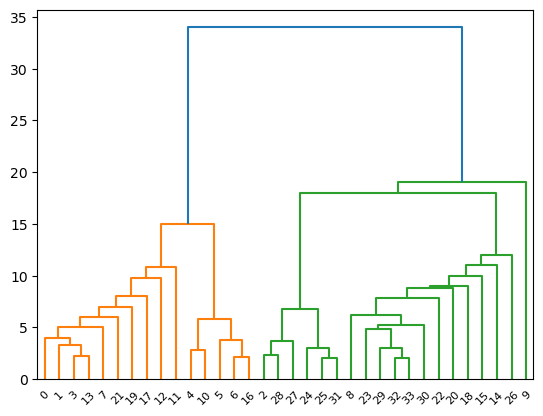

In [4]:
import networkx as nx
from itertools import chain, combinations
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

communities = list(nx.community.girvan_newman(G))

# building initial dict of node_id to each possible subset:
node_id = 0
init_node2community_dict = {node_id: communities[0][0].union(communities[0][1])}
for comm in communities:
    for subset in list(comm):
        if subset not in init_node2community_dict.values():
            node_id += 1
            init_node2community_dict[node_id] = subset

# turning this dictionary to the desired format in @mdml's answer
node_id_to_children = {e: [] for e in init_node2community_dict.keys()}
for node_id1, node_id2 in combinations(init_node2community_dict.keys(), 2):
    for node_id_parent, group in init_node2community_dict.items():
        if len(init_node2community_dict[node_id1].intersection(init_node2community_dict[node_id2])) == 0 and group == init_node2community_dict[node_id1].union(init_node2community_dict[node_id2]):
            node_id_to_children[node_id_parent].append(node_id1)
            node_id_to_children[node_id_parent].append(node_id2)

# also recording node_labels dict for the correct label for dendrogram leaves
node_labels = dict()
for node_id, group in init_node2community_dict.items():
    if len(group) == 1:
        node_labels[node_id] = list(group)[0]
    else:
        node_labels[node_id] = ''

# also needing a subset to rank dict to later know within all k-length merges which came first
subset_rank_dict = dict()
rank = 0
for e in communities[::-1]:
    for p in list(e):
        if tuple(p) not in subset_rank_dict:
            subset_rank_dict[tuple(sorted(p))] = rank
            rank += 1
subset_rank_dict[tuple(sorted(chain.from_iterable(communities[-1])))] = rank

# my function to get a merge height so that it is unique (probably not that efficient)
def get_merge_height(sub):
    sub_tuple = tuple(sorted([node_labels[i] for i in sub]))
    n = len(sub_tuple)
    other_same_len_merges = {k: v for k, v in subset_rank_dict.items() if len(k) == n}
    min_rank, max_rank = min(other_same_len_merges.values()), max(other_same_len_merges.values())
    range = (max_rank-min_rank) if max_rank > min_rank else 1
    return float(len(sub)) + 0.8 * (subset_rank_dict[sub_tuple] - min_rank) / range

# finally using @mdml's magic, slightly modified:
G           = nx.DiGraph(node_id_to_children)
nodes       = G.nodes()
leaves      = set( n for n in nodes if G.out_degree(n) == 0 )
inner_nodes = [ n for n in nodes if G.out_degree(n) > 0 ]

# Compute the size of each subtree
subtree = dict( (n, [n]) for n in leaves )
for u in inner_nodes:
    children = set()
    node_list = list(node_id_to_children[u])
    while len(node_list) > 0:
        v = node_list.pop(0)
        children.add( v )
        node_list += node_id_to_children[v]
    subtree[u] = sorted(children & leaves)

inner_nodes.sort(key=lambda n: len(subtree[n])) # <-- order inner nodes ascending by subtree size, root is last

# Construct the linkage matrix
leaves = sorted(leaves)
index  = dict( (tuple([n]), i) for i, n in enumerate(leaves) )
Z = []
k = len(leaves)
for i, n in enumerate(inner_nodes):
    children = node_id_to_children[n]
    x = children[0]
    for y in children[1:]:
        z = tuple(sorted(subtree[x] + subtree[y]))
        i, j = index[tuple(sorted(subtree[x]))], index[tuple(sorted(subtree[y]))]
        Z.append([i, j, get_merge_height(subtree[n]), len(z)]) # <-- float is required by the dendrogram function
        index[z] = k
        subtree[z] = list(z)
        x = z
        k += 1

# dendrogram
plt.figure()
dendrogram(Z, labels=[node_labels[node_id] for node_id in leaves])
plt.savefig('dendrogram.png')

## Label Propagation y Clique Percolation

In [5]:
import numpy as np
import pandas as pd
from collections import Counter

# Función para seleccionar una etiqueta basada en la mayoría de votos. Si hay un empate, elige aleatoriamente una de las etiquetas con el mayor número de votos
def select_label(x):
    # Cuenta las apariciones de cada etiqueta y convertir el resultado a un DataFrame
    df = pd.DataFrame.from_dict(Counter(x), orient="index", columns=["values"])
    # Selecciona las etiquetas que tienen el número máximo de apariciones
    valid = df[df.values == df.values.max()].index.values
    # Retornar una etiqueta aleatoria en caso de empate
    return np.random.choice(valid)

# Función para realizar una iteración en un nodo específico N del grafo. Actualiza la etiqueta del nodo N basándose en las etiquetas de sus vecinos
def do_iteration(N):
    # Asigna una nueva etiqueta al nodo N, utilizando la función `select_label`
    labels[N] = select_label([labels[ni] for ni in G.neighbors(N)])

# Función para dibujar los nodos del grafo con etiquetas de color
def draw_labels(ax):
    # Asigna colores a los nodos basándose en sus etiquetas actuales
    colors = assign_colors([labels[n] for n in G.nodes])
    nx.draw(G, ax=ax, pos=pos, node_color=colors, edge_color="DimGrey")

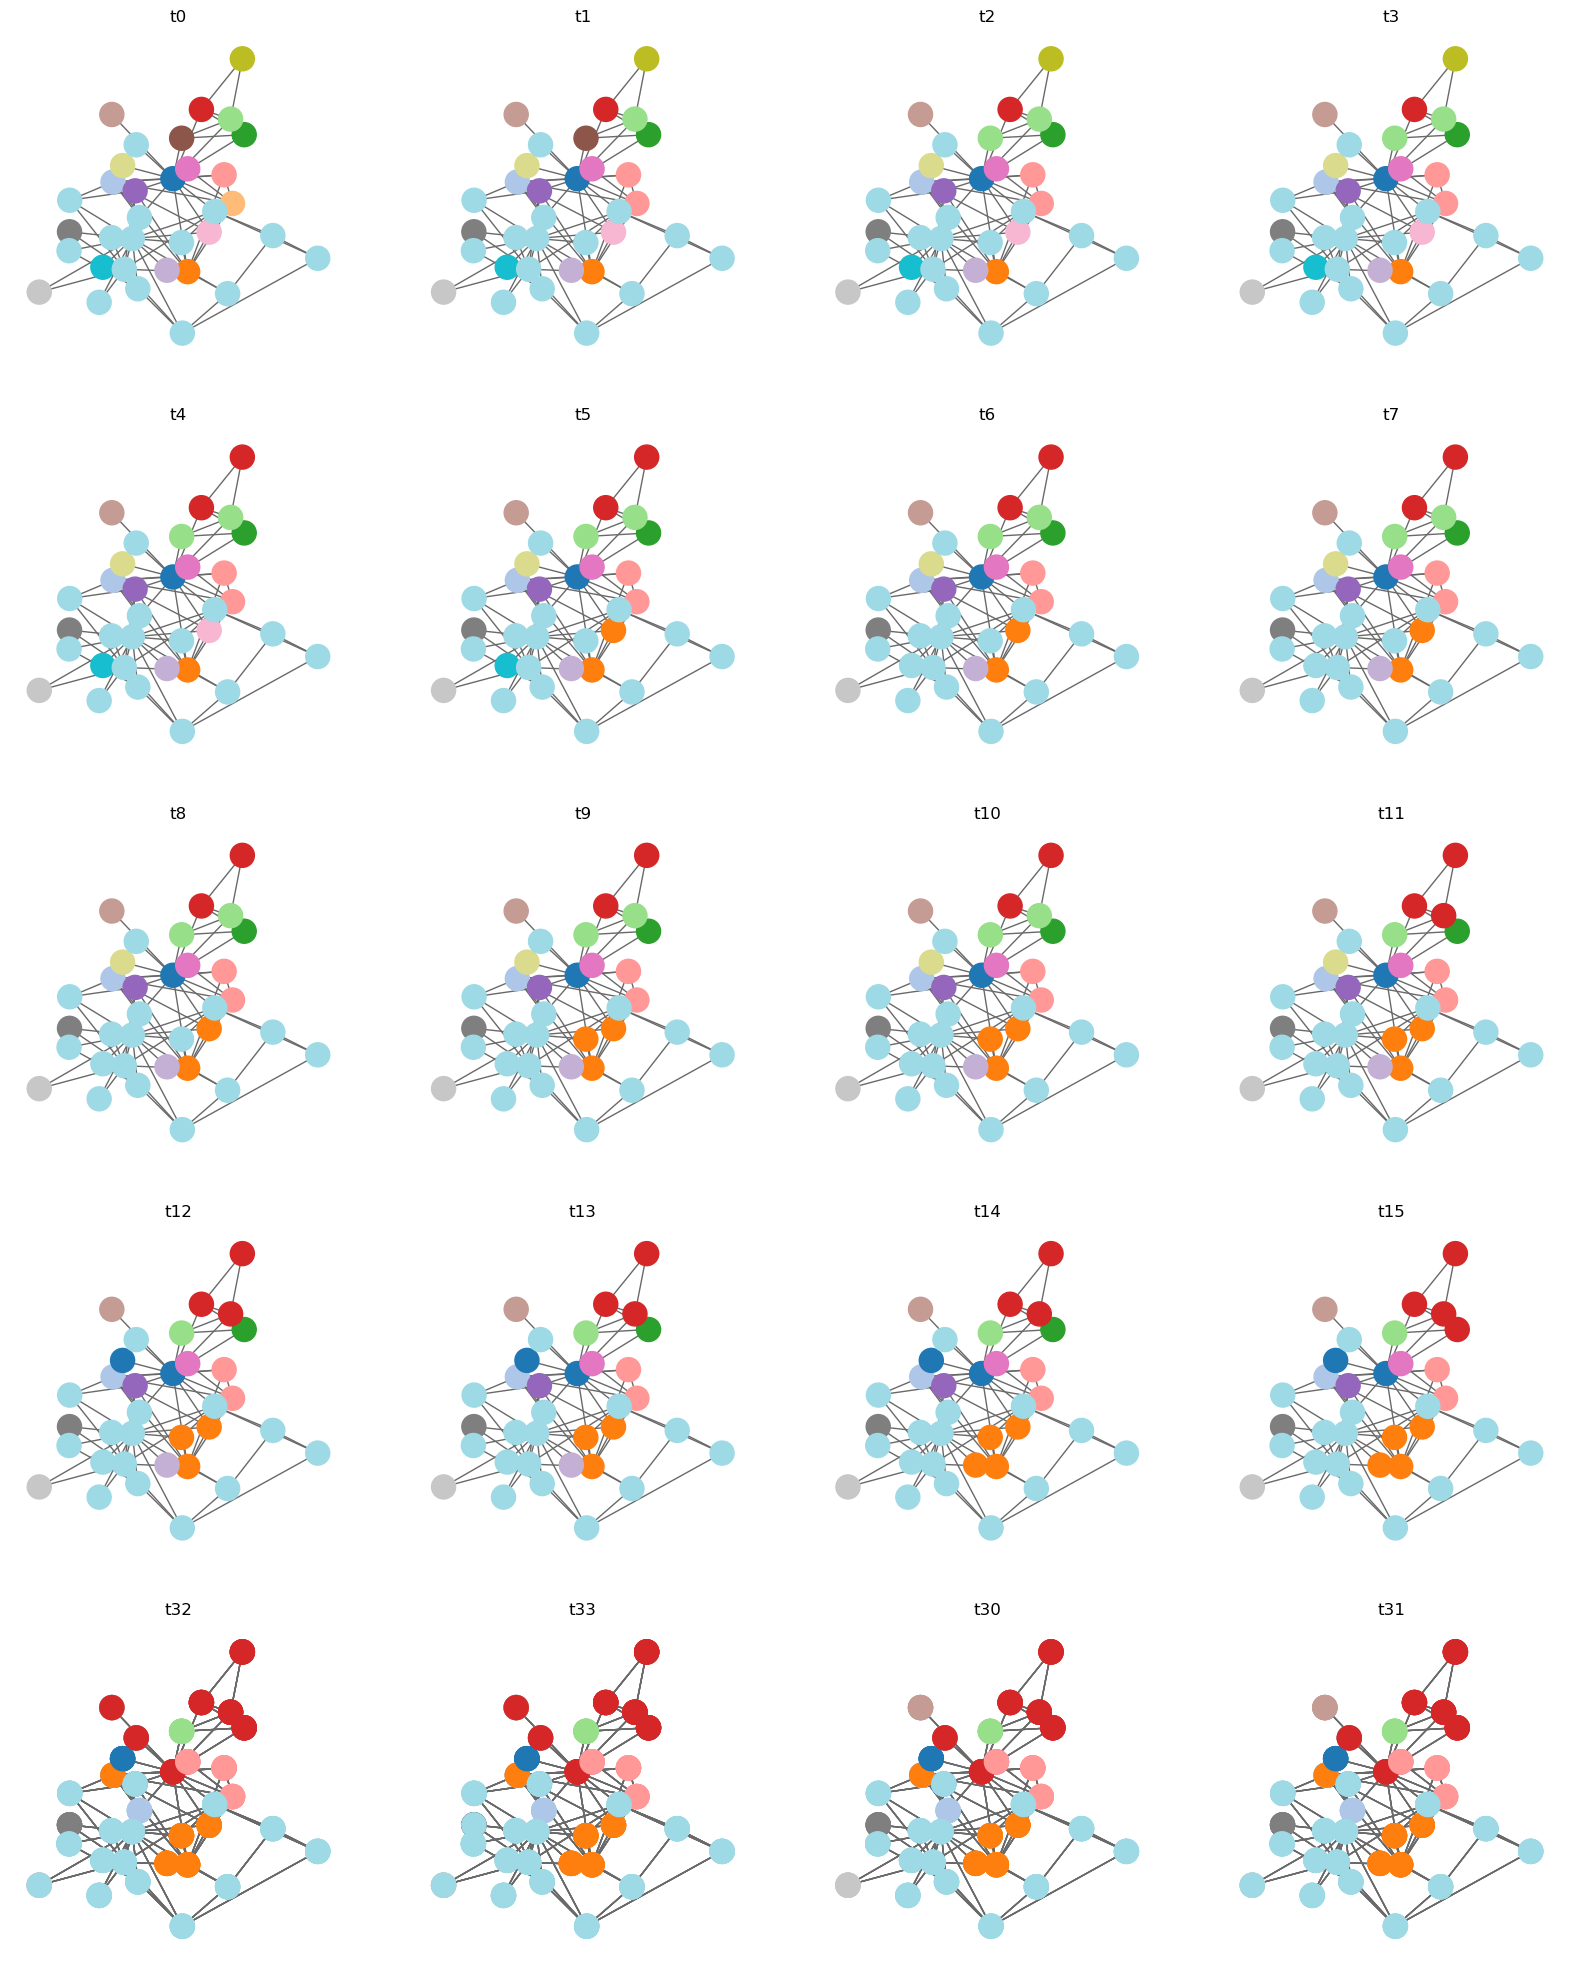

In [9]:
G = nx.karate_club_graph()

# Se define un diccionario labels donde cada nodo tiene como etiqueta su propio identificador k
label = {}
labels = {k: k for k in G.nodes}

N=4 # 4 columnas
M=5 # 5 filas
fig, axs = plt.subplots(M, N, figsize=(N*5,M*5))
pos = nx.kamada_kawai_layout(G)

n_steps = G.number_of_nodes()
interval = n_steps // (N*M)

order = np.random.choice(G.nodes, G.number_of_nodes(), replace=False)
for t in range(n_steps):

    if t % interval == 0:

        i = min((t // interval) // N, M - 1)
        j = min((t // interval) % N, N - 1)
    
        ax = axs[i][j]
        ax.set_title(f"t{t}")

        draw_labels(ax)

    ### LABEL PROPAGATION
    # La función do_iteration(N) realiza un paso iterativo sobre el nodo 𝑁 del grafo 𝐺 G para actualizar su etiqueta basándose
    # en las etiquetas de sus vecinos. Este tipo de iteración es típico en procesos de detección de comunidades o simulaciones de
    # dinámicas de influencia en redes, como la propagación de estados o la formación de consenso.
    do_iteration(order[t])

El algoritmo Louvain es un método para detectar comunidades en un grafo no dirigido. Está diseñado para ser rápido y escalable, lo que lo hace adecuado para grafos grandes. Se ejecuta en dos fases principales de manera iterativa hasta alcanzar un estado óptimo.

## Source code

### Delta modularity

In [43]:
# Función para calcular el cambio en la modularidad si un nodo `n` es removido de su comunidad
def delta_remove(n):

    # Función auxiliar para calcular la contribución al cambio de modularidad al remover un nodo `i`
    def process_node(i):
        # Esta fórmula calcula la diferencia entre el peso de la arista (i, n) y el término de conexión esperado entre
        # los grados de los nodos `i` y `n`, normalizado por el número total de aristas `m`
        return A[i-1][n-1] - (G.degree(i) * G.degree(n)) / (2 * m)
    
    # `m` es el número total de aristas en el grafo
    m = G.number_of_edges()
    
    # `A` es la matriz de adyacencia del grafo `G`, donde cada elemento A[i][j] es el peso de la arista entre los nodos i y j
    # La matriz se crea y convierte en una matriz densa (2D)
    A = nx.adjacency_matrix(G, nodelist=np.sort(G.nodes)).todense()

    # `to_communities_dict(coms)` devuelve un diccionario que mapea cada comunidad a los nodos que la pertenecen
    list_coms = to_communities_dict(coms)
    
    # `nodes` son los nodos de la comunidad a la que pertenece `n`, pero excluyendo a `n`
    nodes = set(list_coms[coms[n]]).difference({n})

    # Se calculan los valores de contribución al cambio de modularidad para cada nodo en `nodes`
    values = np.array([process_node(i) for i in nodes])
    
    # El cambio total al remover el nodo `n` es la suma de los valores calculados, multiplicada por -1/m
    return -(1/m) * values.sum()


# Función para calcular el cambio en la modularidad si un nodo `n` es insertado en una comunidad `cid`
def delta_insert(n, cid):

    # Función auxiliar para calcular la contribución al cambio de modularidad al insertar un nodo `i`
    def process_node(i):
        # Similar a la función `delta_remove`, calcula el cambio en la modularidad por la inserción del nodo `i`
        return A[i-1][n-1] - (G.degree(i) * G.degree(n)) / (2 * m)

    # `m` es el número total de aristas en el grafo
    m = G.number_of_edges()
    
    # `A` es la matriz de adyacencia del grafo `G`, convertida en una matriz densa (2D)
    A = nx.adjacency_matrix(G, nodelist=np.sort(G.nodes)).todense()

    # Se obtiene la lista de nodos en la comunidad `cid`
    list_coms = to_communities_dict(coms)
    
    # `nodes` son los nodos de la comunidad `cid`, pero excluyendo a `n`
    nodes = set(list_coms[cid]).difference({n})

    # Se calculan los valores de contribución al cambio de modularidad para cada nodo en `nodes`
    values = np.array([process_node(i) for i in nodes])
    
    # El cambio total al insertar el nodo `n` es la suma de los valores calculados, multiplicada por 1/m
    return (1/m) * values.sum()


# Función para calcular el cambio total en la modularidad al mover el nodo `n` a la comunidad `cid`
def delta_move(n, cid):
    # El cambio total es la suma de la remoción del nodo de su comunidad actual y la inserción en la nueva comunidad
    return delta_remove(n) + delta_insert(n, cid)

#### Test Delta modularity

In [44]:
# En el código que proporcionas, coms es un diccionario que asigna una comunidad inicial a cada nodo del grafo G.
coms = {n: n-1 for n in G.nodes}
print(f"move 1 to community 0: {delta_move(1,0)}")
print(f"move 2 to community 0: {delta_move(2,0)}")
print(f"move 5 to community 0: {delta_move(5,0)}")

move 1 to community 0: 0.0
move 2 to community 0: 0.00848337950138504
move 5 to community 0: 0.009522160664819942


In [45]:
coms = {n: n-1 for n in G.nodes}
q_before = nx.community.modularity(G, to_communities_list(coms))
coms[2] = 0
q_after = nx.community.modularity(G, to_communities_list(coms))
print(f"move 2 to community 0: {q_after - q_before}")

coms = {n: n-1 for n in G.nodes}
q_before = nx.community.modularity(G, to_communities_list(coms))
coms[5] = 0
q_after = nx.community.modularity(G, to_communities_list(coms))
print(f"move 5 to community 0: {q_after - q_before}")

move 2 to community 0: -0.004674515235457068
move 5 to community 0: 0.009522160664819944


In [46]:
coms = {n: n-1 for n in G.nodes}
coms[2] = 0
print(f"move 1 to community 0: {delta_move(1,0)}")
print(f"move 2 to community 0: {delta_move(2,0)}")
print(f"move 3 to community 0: {delta_move(3,0)}")
print(f"move 5 to community 0: {delta_move(5,0)}")

move 1 to community 0: 0.0
move 2 to community 0: 0.0
move 3 to community 0: 0.0027700831024930752
move 5 to community 0: 0.004068559556786702


In [47]:
coms = {n: n-1 for n in G.nodes}
coms[2] = 0
q_before = nx.community.modularity(G, to_communities_list(coms))

coms[3] = 0
q_after = nx.community.modularity(G, to_communities_list(coms))
print(f"move 3 to community 0: {q_after - q_before}")
coms[3] = 2

coms[5] = 0
q_after = nx.community.modularity(G, to_communities_list(coms))
print(f"move 5 to community 0: {q_after - q_before}")
coms[5] = 4

move 3 to community 0: 0.01592797783933518
move 5 to community 0: 0.01722645429362881


### Fase I

In [48]:
# Función para encontrar el mejor movimiento de un nodo `n` a otra comunidad
def best_move(n, threshold=1e-4):
    # `other_coms` obtiene una lista de todas las comunidades a las que podría moverse el nodo `n`
    # Excluye la comunidad actual del nodo, que se obtiene de `coms[n]`
    other_coms = np.unique(list(coms.values()))
    
    # Usamos `np.vectorize` para aplicar la función `delta_move` a cada comunidad posible
    # `delta_move(n, cid=x)` calcula el cambio en la modularidad al mover `n` a la comunidad `x`
    vdelta = np.vectorize(lambda x: delta_move(n=n,cid=x))
    
    # Calculamos los cambios en la modularidad (deltas) para cada comunidad
    deltas = vdelta(other_coms)
    
    # Si el cambio máximo en la modularidad es mayor que el umbral, retornamos la comunidad con el mejor cambio
    if deltas.max() > threshold:
        return other_coms[int(deltas.argmax())]
    else:
        # Si no hay cambios significativos (por debajo del umbral), no movemos el nodo
        return None

# Función que realiza los movimientos de los nodos en la lista `nodes` a las comunidades con el mejor cambio en modularidad
def do_moves(nodes, draw=True):
    has_change = False  # Flag para verificar si algún nodo cambió de comunidad
    
    # Itera sobre todos los nodos
    for n in nodes:
        # Encuentra la mejor comunidad a la que mover el nodo `n`
        new_com = best_move(n)
        
        # Si hay un movimiento válido (es decir, el nodo tiene una comunidad diferente a la actual)
        if new_com is not None and new_com != coms[n]:
            # Realizamos el cambio de comunidad
            coms[n] = new_com
            print(f"{n} -> {new_com}")  # Imprime el cambio de comunidad
            has_change = True  # Indicamos que hubo un cambio
            
            # Si la opción `draw` es True, dibujamos las comunidades actuales
            if draw:
                _, ax = plt.subplots(1, figsize=(2, 2))
                draw_communities(coms, ax)  # Función que dibuja las comunidades del grafo

    # Retorna si hubo algún cambio en las comunidades
    return has_change

# Función que ejecuta la primera fase del algoritmo de detección de comunidades
def fase_one():
    nodes = list(G.nodes)  # Obtenemos una lista de todos los nodos del grafo
    while True:
        # Mezclamos aleatoriamente el orden de los nodos (para evitar sesgo en el orden de iteración)
        np.random.shuffle(list(G.nodes))
        
        # Realizamos los movimientos de los nodos en sus comunidades correspondientes
        has_change = do_moves(nodes)

        # Si no hubo cambios, terminamos la fase
        if not has_change:
            break

### Fase II

In [49]:
# Función que calcula el número de aristas dentro de una comunidad `cid`
def intra_community_edges(cid):
    # Convierte las comunidades actuales a un diccionario, donde las claves son los ids de comunidad
    # y los valores son las listas de nodos pertenecientes a esas comunidades
    list_coms = to_communities_dict(coms) 
    
    # Obtiene los nodos que pertenecen a la comunidad `cid`
    nodes = list_coms[cid]

    # Creamos un subgrafo con los nodos de la comunidad `cid`
    sg = nx.subgraph(G, nodes)

    # Retorna el número de aristas dentro de la comunidad `cid`
    return sg.number_of_edges()

# Función que calcula el peso de las aristas entre dos conjuntos de nodos `nodes_1` y `nodes_2`
def calculate_edge_weight(nodes_1, nodes_2):
    weight = 0  # Inicializamos el peso a 0
    # Itera sobre todos los nodos en `nodes_1` y `nodes_2`
    for node_1 in nodes_1:
        for node_2 in nodes_2:
            # Si existe una arista entre `node_1` y `node_2`, sumamos su peso
            if G.has_edge(node_1, node_2):
                weight += G.edges[node_1, node_2]["weight"]
    
    # Retorna el peso total de las aristas entre `nodes_1` y `nodes_2`
    return weight    
    
# Función que ejecuta la segunda fase del algoritmo de detección de comunidades
def fase_two():
    # Creamos un nuevo grafo `G_new` donde las comunidades del grafo original `G` son los nodos
    # y las aristas entre comunidades se definen por los pesos de las aristas entre los nodos
    # que pertenecen a diferentes comunidades.
    G_new = nx.quotient_graph(
        G,  # Grafo original
        partition=to_communities_dict(coms),  # Diccionario de particiones (comunidades)
        edge_data=lambda sx, sy: {"weight": calculate_edge_weight(sx, sy)},  # Calculamos los pesos de las aristas
    )

    # Renombramos los nodos del nuevo grafo con los ids de las comunidades a las que pertenecen
    G_new = nx.relabel_nodes(G_new, {s: coms[list(s).pop()] for s in G_new.nodes()})

    # Para cada comunidad, añadimos una arista dentro de la comunidad con el peso calculado por `intra_community_edges`.
    # Cada comunidad en el grafo G_new tiene una arista a sí misma que refleja el peso total de las aristas dentro de la comunidad en el grafo original.
    for c_id in np.unique(list(coms.values())):
        G_new.add_edge(c_id, c_id, weight=intra_community_edges(c_id))

    # Retorna el nuevo grafo `G_new` que representa las comunidades como nodos
    return G_new

## Example

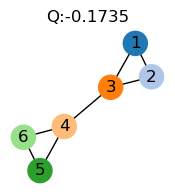

In [50]:
G = nx.from_edgelist([
    (1,2),
    (1,3),
    (2,3),
    (3,4),
    (4,5),
    (4,6),
    (5,6)
])
nx.set_edge_attributes(G, 1, "weight")

_,ax = plt.subplots(1,figsize=(2,2))
coms = {n: n-1 for n in G.nodes}

draw_communities(coms,ax)

1 -> 1
3 -> 1
4 -> 4
5 -> 5
4 -> 5


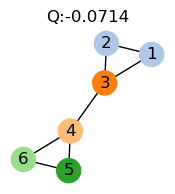

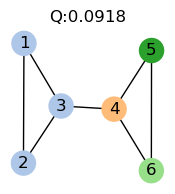

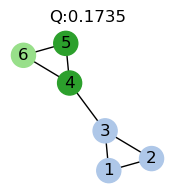

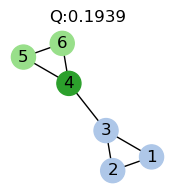

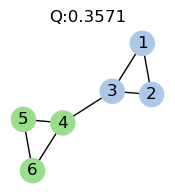

In [51]:
fase_one()

{(1, 5): Text(0.0, 0.0, '1'),
 (1, 1): Text(1.0, 4.371138828673794e-08, '3'),
 (5, 5): Text(-1.0, -4.371138828673794e-08, '3')}

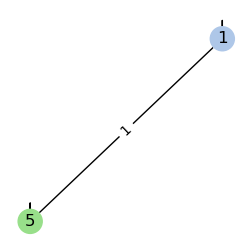

In [53]:
G_new = fase_two()
_,ax = plt.subplots(1,figsize=(3,3))

colors = assign_colors(list(G_new.nodes))
labels = nx.get_edge_attributes(G,'weight')

pos = nx.kamada_kawai_layout(G_new)
nx.draw(G_new, ax=ax, with_labels=True, node_color=colors, pos=pos)
labels = nx.get_edge_attributes(G_new,'weight')
nx.draw_networkx_edge_labels(G_new,pos,edge_labels=labels)

## Implementacion en Networkx

In [54]:
list(nx.community.louvain_communities(G))

[{1, 2, 3}, {4, 5, 6}]

Text(0.5, 1.0, 'Modularity: 0.5416')

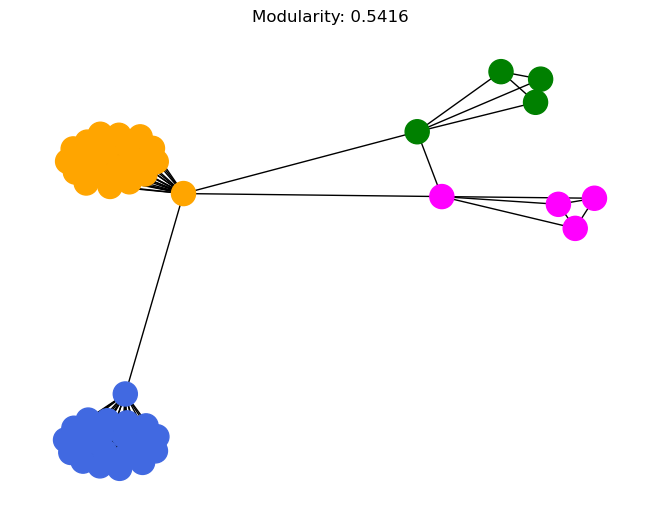

In [60]:
import numpy as np
import networkx as nx

# Función para añadir un "clique" (grafo completo) de tamaño `n` al grafo `G` y asignar un color a sus nodos
def add_clique(G, n, color):
    N = G.number_of_nodes()  # Número actual de nodos en el grafo original G
    clique = nx.complete_graph(n)  # Crear un nuevo grafo completo (clique) de tamaño `n`
    
    # Asignar el color proporcionado a todos los nodos del nuevo clique
    nx.set_node_attributes(clique, color, "color")
    
    # Renombrar los nodos del clique para que sus identificadores no entren en conflicto con los del grafo original
    labels = {n: n+N for n in G.nodes}  # Renombrar los nodos del clique añadiendo `N` al nombre de cada nodo
    clique = nx.relabel_nodes(clique, labels)  # Aplicar los nuevos nombres a los nodos del clique

    # Añadir los nodos y las aristas del clique al grafo original `G`
    G.add_nodes_from(clique.nodes(data=True))  # Añadir nodos del clique al grafo G con sus atributos (color)
    G.add_edges_from(clique.edges)  # Añadir las aristas del clique al grafo G

    return clique  # Retorna el grafo del clique creado

# Función para crear un ejemplo de grafo con múltiples cliques y conexiones entre ellos
def example_graph(m, p):
    # Crear un grafo completo con `m` nodos
    G = nx.complete_graph(m)
    
    # Asignar el color "royalBlue" a todos los nodos del grafo original G
    nx.set_node_attributes(G, "royalBlue", "color")
    
    # Seleccionar un nodo aleatorio del grafo original `G` (esto será el punto de inicio de la comunidad 1)
    c1_point = np.random.choice(G.nodes)
    
    # Añadir un clique de tamaño `m` al grafo con color "orange" y seleccionar un nodo aleatorio de este clique
    c2 = add_clique(G, m, "orange")
    c2_point = np.random.choice(c2.nodes)
    
    # Añadir un clique de tamaño `p` al grafo con color "green" y seleccionar un nodo aleatorio de este clique
    c3 = add_clique(G, p, "green")
    c3_point = np.random.choice(c3.nodes)
    
    # Añadir otro clique de tamaño `p` al grafo con color "magenta" y seleccionar un nodo aleatorio de este clique
    c4 = add_clique(G, p, "magenta")
    c4_point = np.random.choice(c4.nodes)
    
    # Conectar nodos seleccionados aleatoriamente entre los diferentes cliques
    # Estas aristas representan las conexiones entre diferentes comunidades (cliques)
    G.add_edge(c1_point, c2_point)  # Conectar un nodo del clique 1 con uno del clique 2
    G.add_edge(c2_point, c3_point)  # Conectar un nodo del clique 2 con uno del clique 3
    G.add_edge(c2_point, c4_point)  # Conectar un nodo del clique 2 con uno del clique 4
    G.add_edge(c3_point, c4_point)  # Conectar un nodo del clique 3 con uno del clique 4

    return G  # Retornar el grafo completo con los cliques y sus conexiones

G = example_graph(20, 4)

colors = [d["color"] for _,d in G.nodes(data=True)]
nx.draw(G, node_color=colors)
plt.title(f"Modularity: {q:.4f}")


Text(0.5, 1.0, 'Modularity: 0.5416')

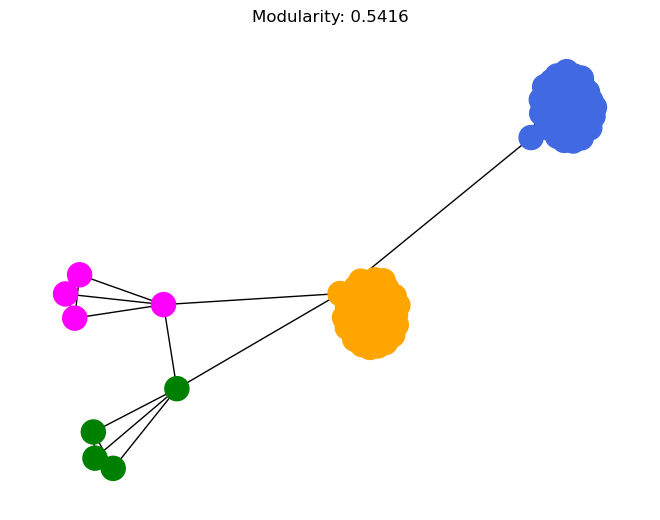

In [59]:
G = example_graph(40, 4)

colors = [d["color"] for _,d in G.nodes(data=True)]
nx.draw(G, node_color=colors)
plt.title(f"Modularity: {q:.4f}")

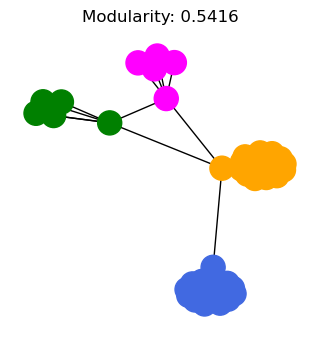

In [62]:
import matplotlib.pyplot as plt  # Importar la librería de visualización de gráficos

# Crear un grafo de ejemplo con 20 nodos en el primer clique (comunidad) y 5 nodos en cada uno de los siguientes
G = example_graph(20, 5)

# Configurar el tamaño de la figura para la visualización
plt.figure(figsize=(3, 3))

# Obtener todos los nodos y sus atributos de color
nodes, data = zip(*list(G.nodes(data=True)))

# Convertir los atributos de los nodos (como el color) en un DataFrame de pandas
df_coms = pd.DataFrame(data, index=nodes).reset_index().groupby("color").aggregate(lambda x: list(x))

# Calcular la modularidad de la partición del grafo utilizando los colores de las comunidades como partición
q = nx.community.modularity(G, df_coms["index"].values.tolist())

# Crear una lista de colores para los nodos, basada en el atributo "color" de cada nodo
colors = [d["color"] for _, d in G.nodes(data=True)]

# Dibujar el grafo, coloreando los nodos según su comunidad (atributo "color")
nx.draw(G, node_color=colors)

# Título de la visualización mostrando el valor de la modularidad calculada
plt.title(f"Modularity: {q:.4f}")

# Mostrar el gráfico generado
plt.show()

Encontrar la modularidad máxima es equivalente a buscar el equilibrio ideal entre el número de términos en la suma, es decir, el número de módulos, y el valor de cada término

Text(0.5, 1.0, 'Modularity: 0.5426')

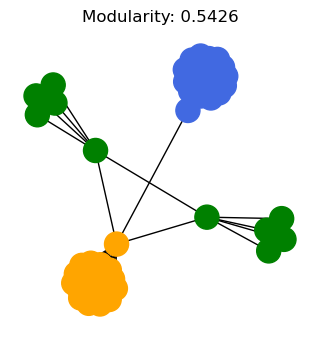

In [64]:
import matplotlib.pyplot as plt

G = example_graph(20,5)

for n,d in G.nodes(data=True):
    if d["color"] == "magenta":
        G.nodes[n]["color"]="green"

nodes, data = zip(*list(G.nodes(data=True)))
df_coms = pd.DataFrame(data, index=nodes).reset_index().groupby("color").aggregate(lambda x: list(x))
q = nx.community.modularity(G, df_coms["index"].values.tolist())

plt.figure(figsize=(3,3))

colors = [d["color"] for _,d in G.nodes(data=True)]
nx.draw(G, node_color=colors)
plt.title(f"Modularity: {q:.4f}")

In [66]:
!pip install cdlib

     ---------------------------------------- 0.0/204.6 kB ? eta -:--:--
     ----- ------------------------------- 30.7/204.6 kB 640.0 kB/s eta 0:00:01
     ---------------------- --------------- 122.9/204.6 kB 1.2 MB/s eta 0:00:01
     ------------------------------------ - 194.6/204.6 kB 1.7 MB/s eta 0:00:01
     -------------------------------------- 204.6/204.6 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/263.6 kB ? eta -:--:--
   ----------------------- ---------------- 153.6/263.6 kB 4.6 MB/s eta 0:00:01
   ---------------------------------------- 263.6/263.6 kB 3.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   --- ------------------------------------ 0.2/2.0 MB 5.0 MB/s eta 0:00:01
   --------- ------------------------------ 0.5/2.0 MB 6.0 MB/s eta 0:00:01
   -------------------- ------------------- 1.0/2.0 M

In [70]:
!pip install igraph leidenalg graph_tool infomap leidenalg wurlitzer bayanpy pyclustering ASLPAw --quiet

ERROR: Could not find a version that satisfies the requirement graph_tool (from versions: none)
ERROR: No matching distribution found for graph_tool


ModuleNotFoundError: Optional dependency not satisfied: install igraph and leidenalg to use the selected feature.

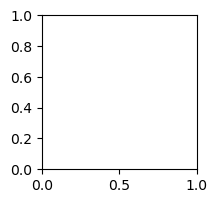

In [72]:
from cdlib.algorithms import leiden

G = nx.from_edgelist([
    (1,2),
    (1,3),
    (2,3),
    (3,4),
    (4,5),
    (4,6),
    (5,6)
])
nx.set_edge_attributes(G, 1, "weight")

_,ax = plt.subplots(1,figsize=(2,2))
leiden_coms = leiden(G).to_node_community_map()
print(leiden_coms)

coms = {k:v[0] for k,v in leiden(G).to_node_community_map().items()}
draw_communities(coms,ax)

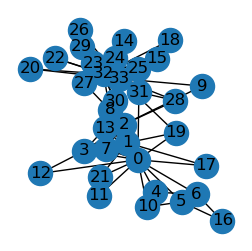

In [42]:
import networkx as nx

G = nx.karate_club_graph()

_,ax = plt.subplots(1,figsize=(3,3))
nx.draw(G, ax=ax, with_labels=True)

## Find all maximal cliques

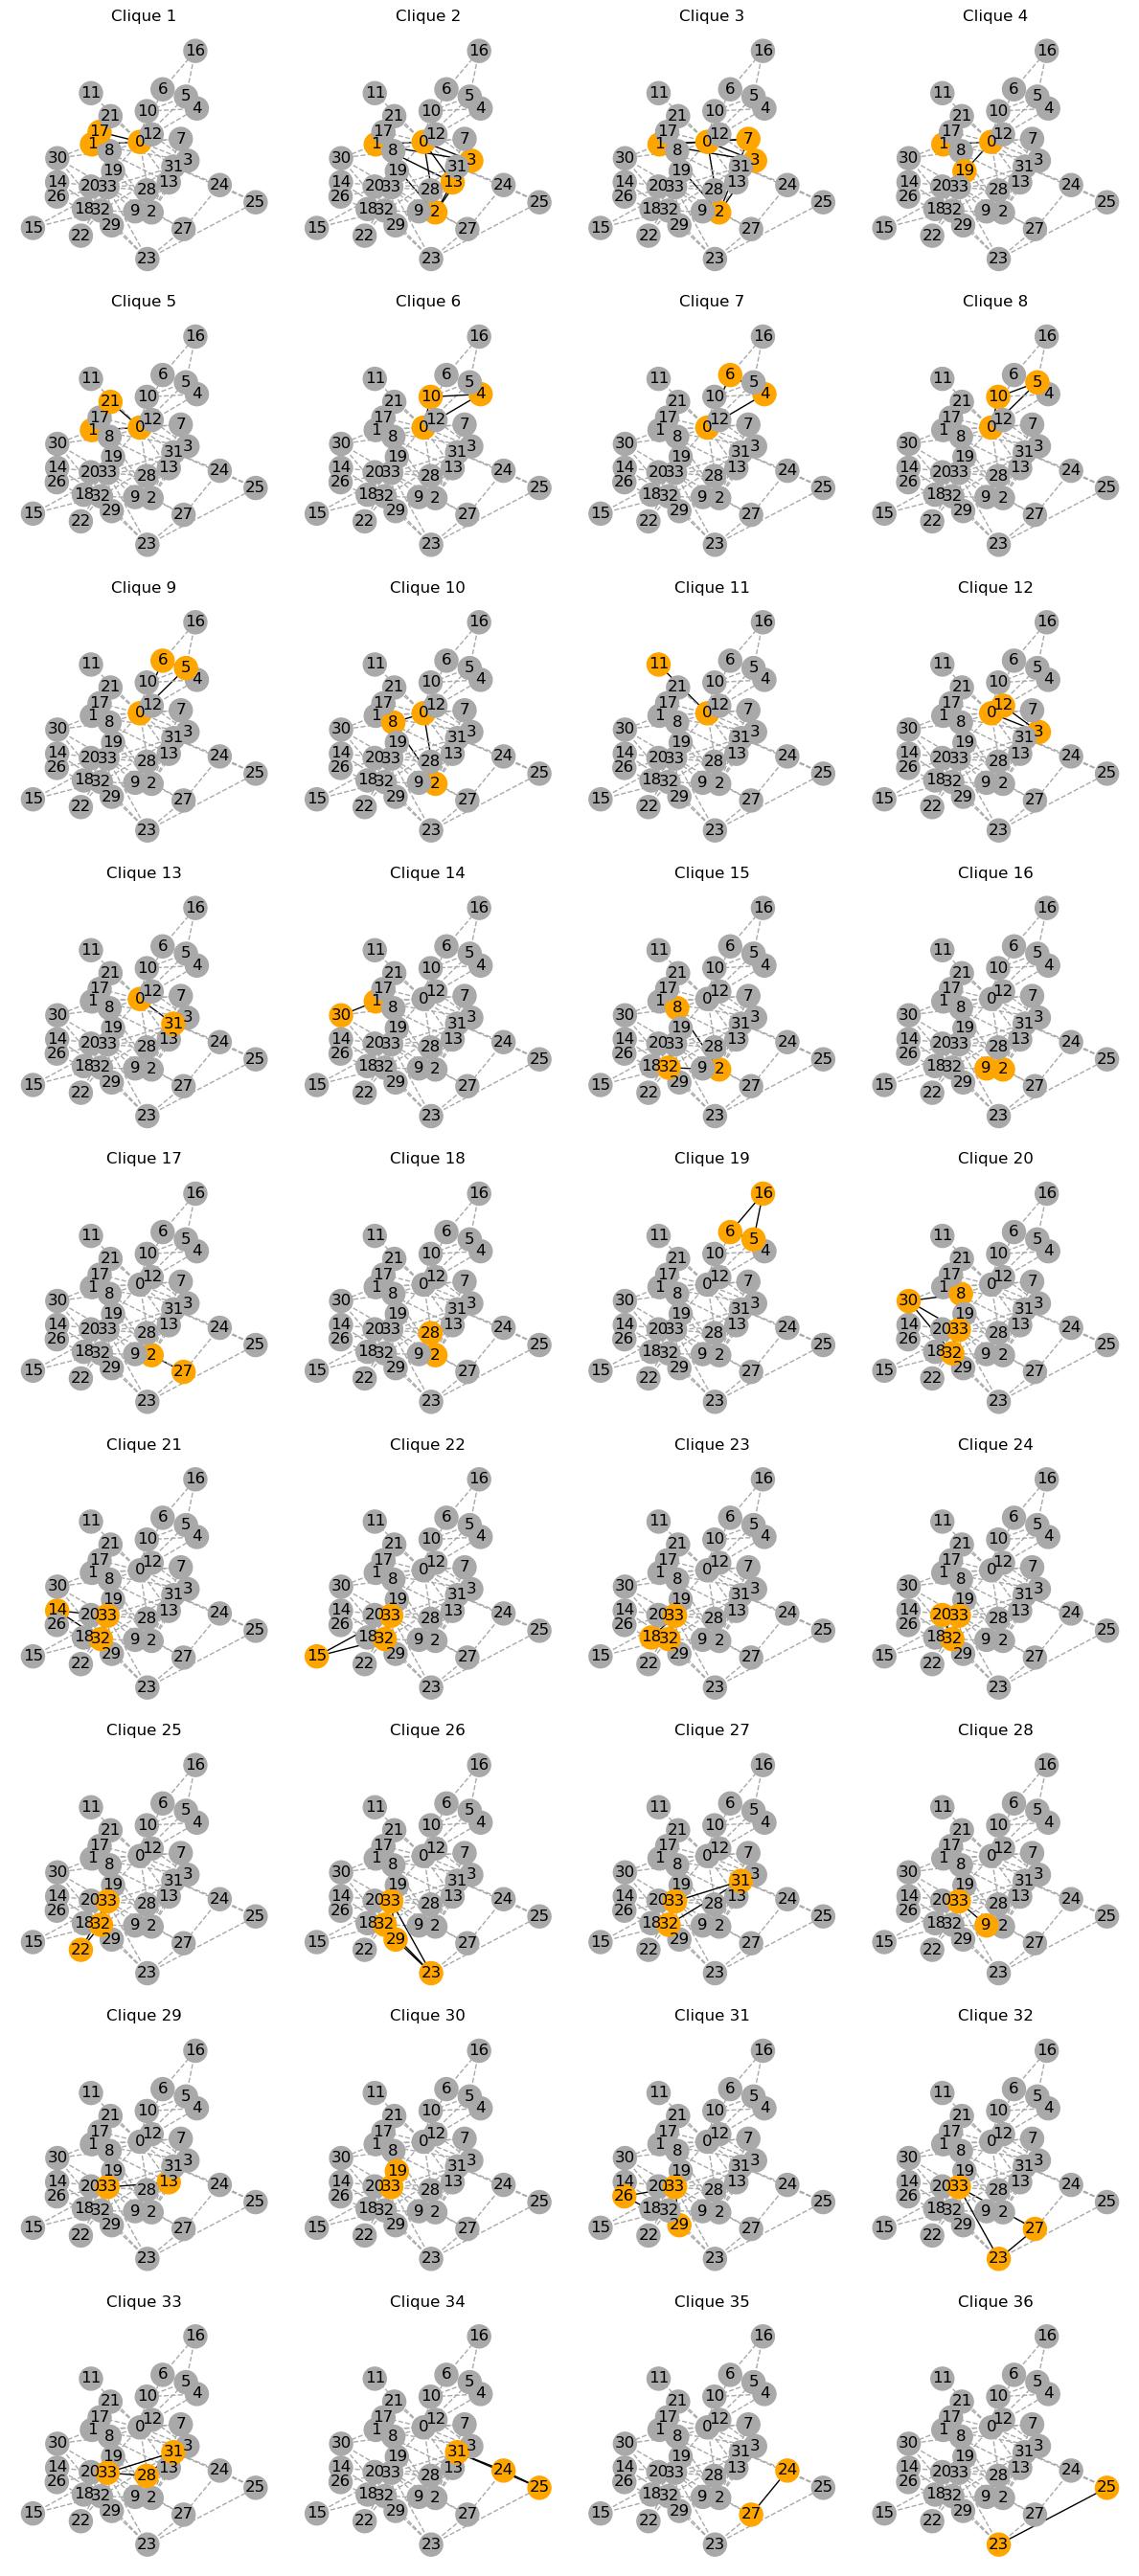

In [43]:
cliques = list(nx.find_cliques(G))

# filas necesarias para mostrar 4 cliques por fila
n_rows = (len(cliques) + 3) // 4  # garantiza que haya suficientes filas para los cliques restantes

_, axs = plt.subplots(n_rows, 4, figsize=(12, n_rows * 3))  # Ajusta el tamaño de la figura

axs = axs.flatten()

colormap = plt.cm.tab10

for cid, nodes in enumerate(cliques):
    colors = ["orange" if n in nodes else "darkgray" for n in G.nodes]
    edges = ["black" if u in nodes and v in nodes else "darkgray" for u, v in G.edges]
    style = ["-" if u in nodes and v in nodes else "--" for u, v in G.edges]
    nx.draw_kamada_kawai(G, node_color=colors, edge_color=edges, style=style, ax=axs[cid], with_labels=True)
    axs[cid].set_title(f"Clique {cid + 1}")

# Elimina los ejes adicionales si el número de cliques no es múltiplo de 4
for i in range(cid + 1, len(axs)):
    axs[i].axis('off')

plt.tight_layout()  # Ajusta el diseño para evitar solapamientos
plt.show()

## Make clique-clique overlap matrix

### Sources

Text(0.5, 1.0, 'Nº nodes overlap: 2')

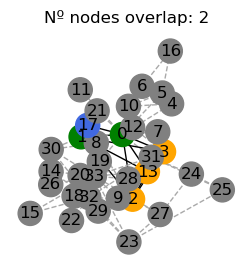

In [44]:
import numpy as np

def overlap_nodes(clique_1, clique_2):
    return len(set(clique_1).intersection(set(clique_2)))

def draw_overlap_cliques(clique_1, clique_2, ax):
    overlap = set(clique_1).intersection(set(clique_2))
    all = set(clique_1).union(set(clique_2))
    
    colors = ["green" if n in overlap else ("royalBlue" if n in clique_1 else ("orange" if n in clique_2 else "gray")) for n in G.nodes]
    edges = ["black" if u in all and v in all else "darkgray" for u,v in G.edges]
    style = ["-" if u in all and v in all else "--" for u,v in G.edges]
    nx.draw_kamada_kawai(G, node_color=colors, edge_color=edges, style=style, ax=ax, with_labels=True)

_,ax = plt.subplots(1,figsize=(3,3))
draw_overlap_cliques(cliques[0], cliques[1], ax)
ax.set_title(f"Nº nodes overlap: {overlap_nodes(cliques[0], cliques[1])}")

### Create matrix

<Axes: >

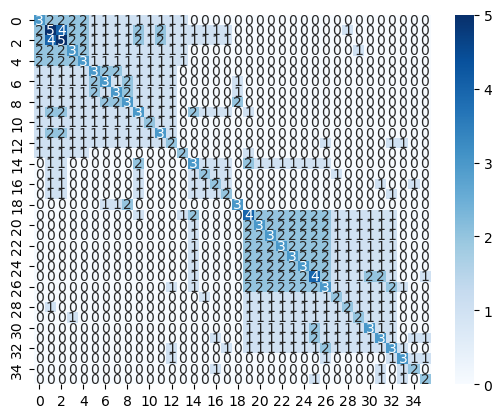

In [45]:
import numpy as np
import seaborn as sns
from itertools import product

N = len(cliques)
m_clique_o = np.array([overlap_nodes(cliques[u],cliques[v]) for u,v in product(range(N), repeat=2)]).reshape(N,N)

sns.heatmap(m_clique_o, cmap="Blues", annot=True)

### Clean matrix

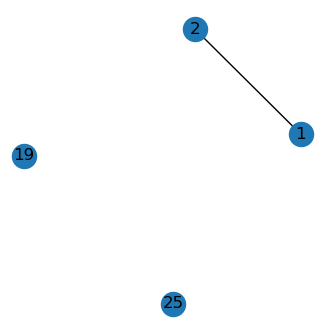

In [46]:
K = 4

# remove the cliques smaller than K
np.fill_diagonal(m_clique_o, np.where(np.diag(m_clique_o) < K, 0, np.diag(m_clique_o)))

# remove the connections smaller than K-1
m_clique_o[m_clique_o < (K-1)] = 0

# remove weights
m_clique_o[m_clique_o > 0] = 1

# make clique graph
G_cliques = nx.from_numpy_array(m_clique_o)

# remove sporius communities and self loops
G_cliques.remove_nodes_from([n for n in G_cliques.nodes if not G_cliques.has_edge(n,n)])
G_cliques.remove_edges_from(nx.selfloop_edges(G_cliques))

_,ax = plt.subplots(1,figsize=(4,4))
nx.draw_kamada_kawai(G_cliques, ax=ax, with_labels=True)